# Importing Libraries

In [89]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
import category_encoders as ce
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
plt.style.use('bmh')
import imblearn
from imblearn.over_sampling import SMOTE

# Installation of Libraries

In [2]:
!pip install category_encoders

You should consider upgrading via the 'c:\users\ag95028\appdata\local\conda\conda\envs\myenv\python.exe -m pip install --upgrade pip' command.


In [3]:
#nRowsRead = 10000 #

In [5]:
df_train = pd.read_csv('Train.csv',delimiter=',')

In [6]:
df_train.head()

,ID,Length of vehicle in cm,weight of vehicle in kg,Number of axles,DrivingStyle
0,DR_24526,1265,10243,2,2
1,DR_30052,1680,30871,6,2
2,DR_40928,936,3224,4,2
3,DR_66033,1503,3315,4,2
4,DR_45266,929,3022,4,2


In [7]:
df_train.shape

(12994, 5)

In [8]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [9]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [10]:
plotPerColumnDistribution(df_train, 10, 5)

In [11]:
plt.figure(figsize=(13,8))
sns.heatmap(df_train.corr(), annot=True )

In [12]:
plotScatterMatrix(df_train, 12, 10)

In [13]:
#df_vehicle = pd.read_csv('Train_Vehicletravellingdata.csv',delimiter=',', nrows = nRowsRead)

In [14]:
df_vehicle = pd.read_csv('Train_Vehicletravellingdata.csv',delimiter=',')

In [15]:
df_vehicle.head()

,ID,Date time,Lane of the road,Speed of the vehicle (kph),ID of the preceding vehicle,Speed of the preceding vehicle,Weight of the preceding vehicle,Length of preceding vehicle,Time gap with the preceeding vehicle in seconds,Road Condition
0,DR_24526,21-03-2012 09:14,1,81,57227,87,16986,941,94.0,Dry
1,DR_24526,21-03-2012 09:15,1,88,57229,81,1708,551,11.0,Dry
2,DR_24526,21-03-2012 09:15,1,88,57230,88,22892,1698,4.0,Dry
3,DR_24526,21-03-2012 09:15,2,84,57228,89,1945,544,127.0,Dry
4,DR_24526,21-03-2012 09:15,1,89,57231,88,13787,1893,42.0,Dry


In [16]:
plotPerColumnDistribution(df_vehicle, 10, 5)

In [17]:
plt.figure(figsize=(13,8))
sns.heatmap(df_vehicle.corr(), annot=True )

In [18]:
plotScatterMatrix(df_vehicle, 12, 10)

In [19]:
#df_weather = pd.read_csv('Train_WeatherData.csv',delimiter=',', nrows = nRowsRead)
df_weather = pd.read_csv('Train_WeatherData.csv',delimiter=',')

In [20]:
df = df_vehicle.merge(df_weather, on = ['ID','Date time'] )

In [21]:
df = df.merge(df_train,on='ID')

In [22]:
df.shape

(573008, 21)

In [24]:
# check the data type of our date column
df['Date time'].dtype

dtype('O')

In [25]:
# create a new column, date_parsed, with the parsed dates
df['datetime'] = df['Date time'].apply(lambda x: pd.Timestamp(x))

In [26]:
#df.set_index('datetime', inplace=True)
df.set_index(['ID', 'datetime'], inplace=True)

In [27]:
del df['Date time']

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 573008 entries, ('DR_24526', Timestamp('2012-03-21 09:14:00')) to ('DR_56117', Timestamp('2013-04-30 16:57:00'))
Data columns (total 19 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Lane of the road                                 573008 non-null  int64  
 1   Speed of the vehicle (kph)                       573008 non-null  int64  
 2   ID of the preceding vehicle                      573008 non-null  int64  
 3   Speed of the preceding vehicle                   573008 non-null  int64  
 4   Weight of the preceding vehicle                  573008 non-null  int64  
 5   Length of preceding vehicle                      573008 non-null  int64  
 6   Time gap with the preceeding vehicle in seconds  559117 non-null  float64
 7   Road Condition                                   573008 non-null  object 
 8   Weather d

In [29]:
# check for missing values
df.isnull().sum()

Lane of the road                                       0
Speed of the vehicle (kph)                             0
ID of the preceding vehicle                            0
Speed of the preceding vehicle                         0
Weight of the preceding vehicle                        0
Length of preceding vehicle                            0
Time gap with the preceeding vehicle in seconds    13891
Road Condition                                         0
Weather details-Air temperature                     6709
Precipitation                                          0
Precipitation intensity                                0
Relative humidity                                   6861
Wind direction                                      6898
Wind speed in m/s                                   8136
Day time                                               0
Length of vehicle in cm                                0
weight of vehicle in kg                                0
Number of axles                

In [30]:
df.columns

Index(['Lane of the road', 'Speed of the vehicle (kph)',
       'ID of the preceding vehicle', 'Speed of the preceding vehicle',
       'Weight of the preceding vehicle', 'Length of preceding vehicle',
       'Time gap with the preceeding vehicle in seconds', 'Road Condition',
       'Weather details-Air temperature', 'Precipitation',
       'Precipitation intensity', 'Relative humidity', 'Wind direction',
       'Wind speed in m/s', 'Day time', 'Length of vehicle in cm',
       'weight of vehicle in kg', 'Number of axles', 'DrivingStyle'],
      dtype='object')

# EDA

In [31]:
def initial_eda(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))

In [32]:
initial_eda(df)

# Handle missing values

In [33]:
df.fillna(df.mean(), inplace=True)

2    316692
3    180334
1     75982
Name: DrivingStyle, dtype: int64

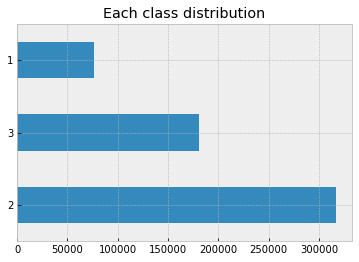

In [34]:
df['DrivingStyle'].value_counts().plot.barh()
plt.title("Each class distribution")
df['DrivingStyle'].value_counts()

In [35]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

In [36]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\AG95028\AppData\Local\conda\conda\envs\myenv\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\AG95028\AppData\Local\conda\conda\envs\myenv\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\AG95028\AppData\Local\conda\conda\envs\myenv\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\AG95028\AppData\Local\conda\conda\envs\myenv\lib\sit

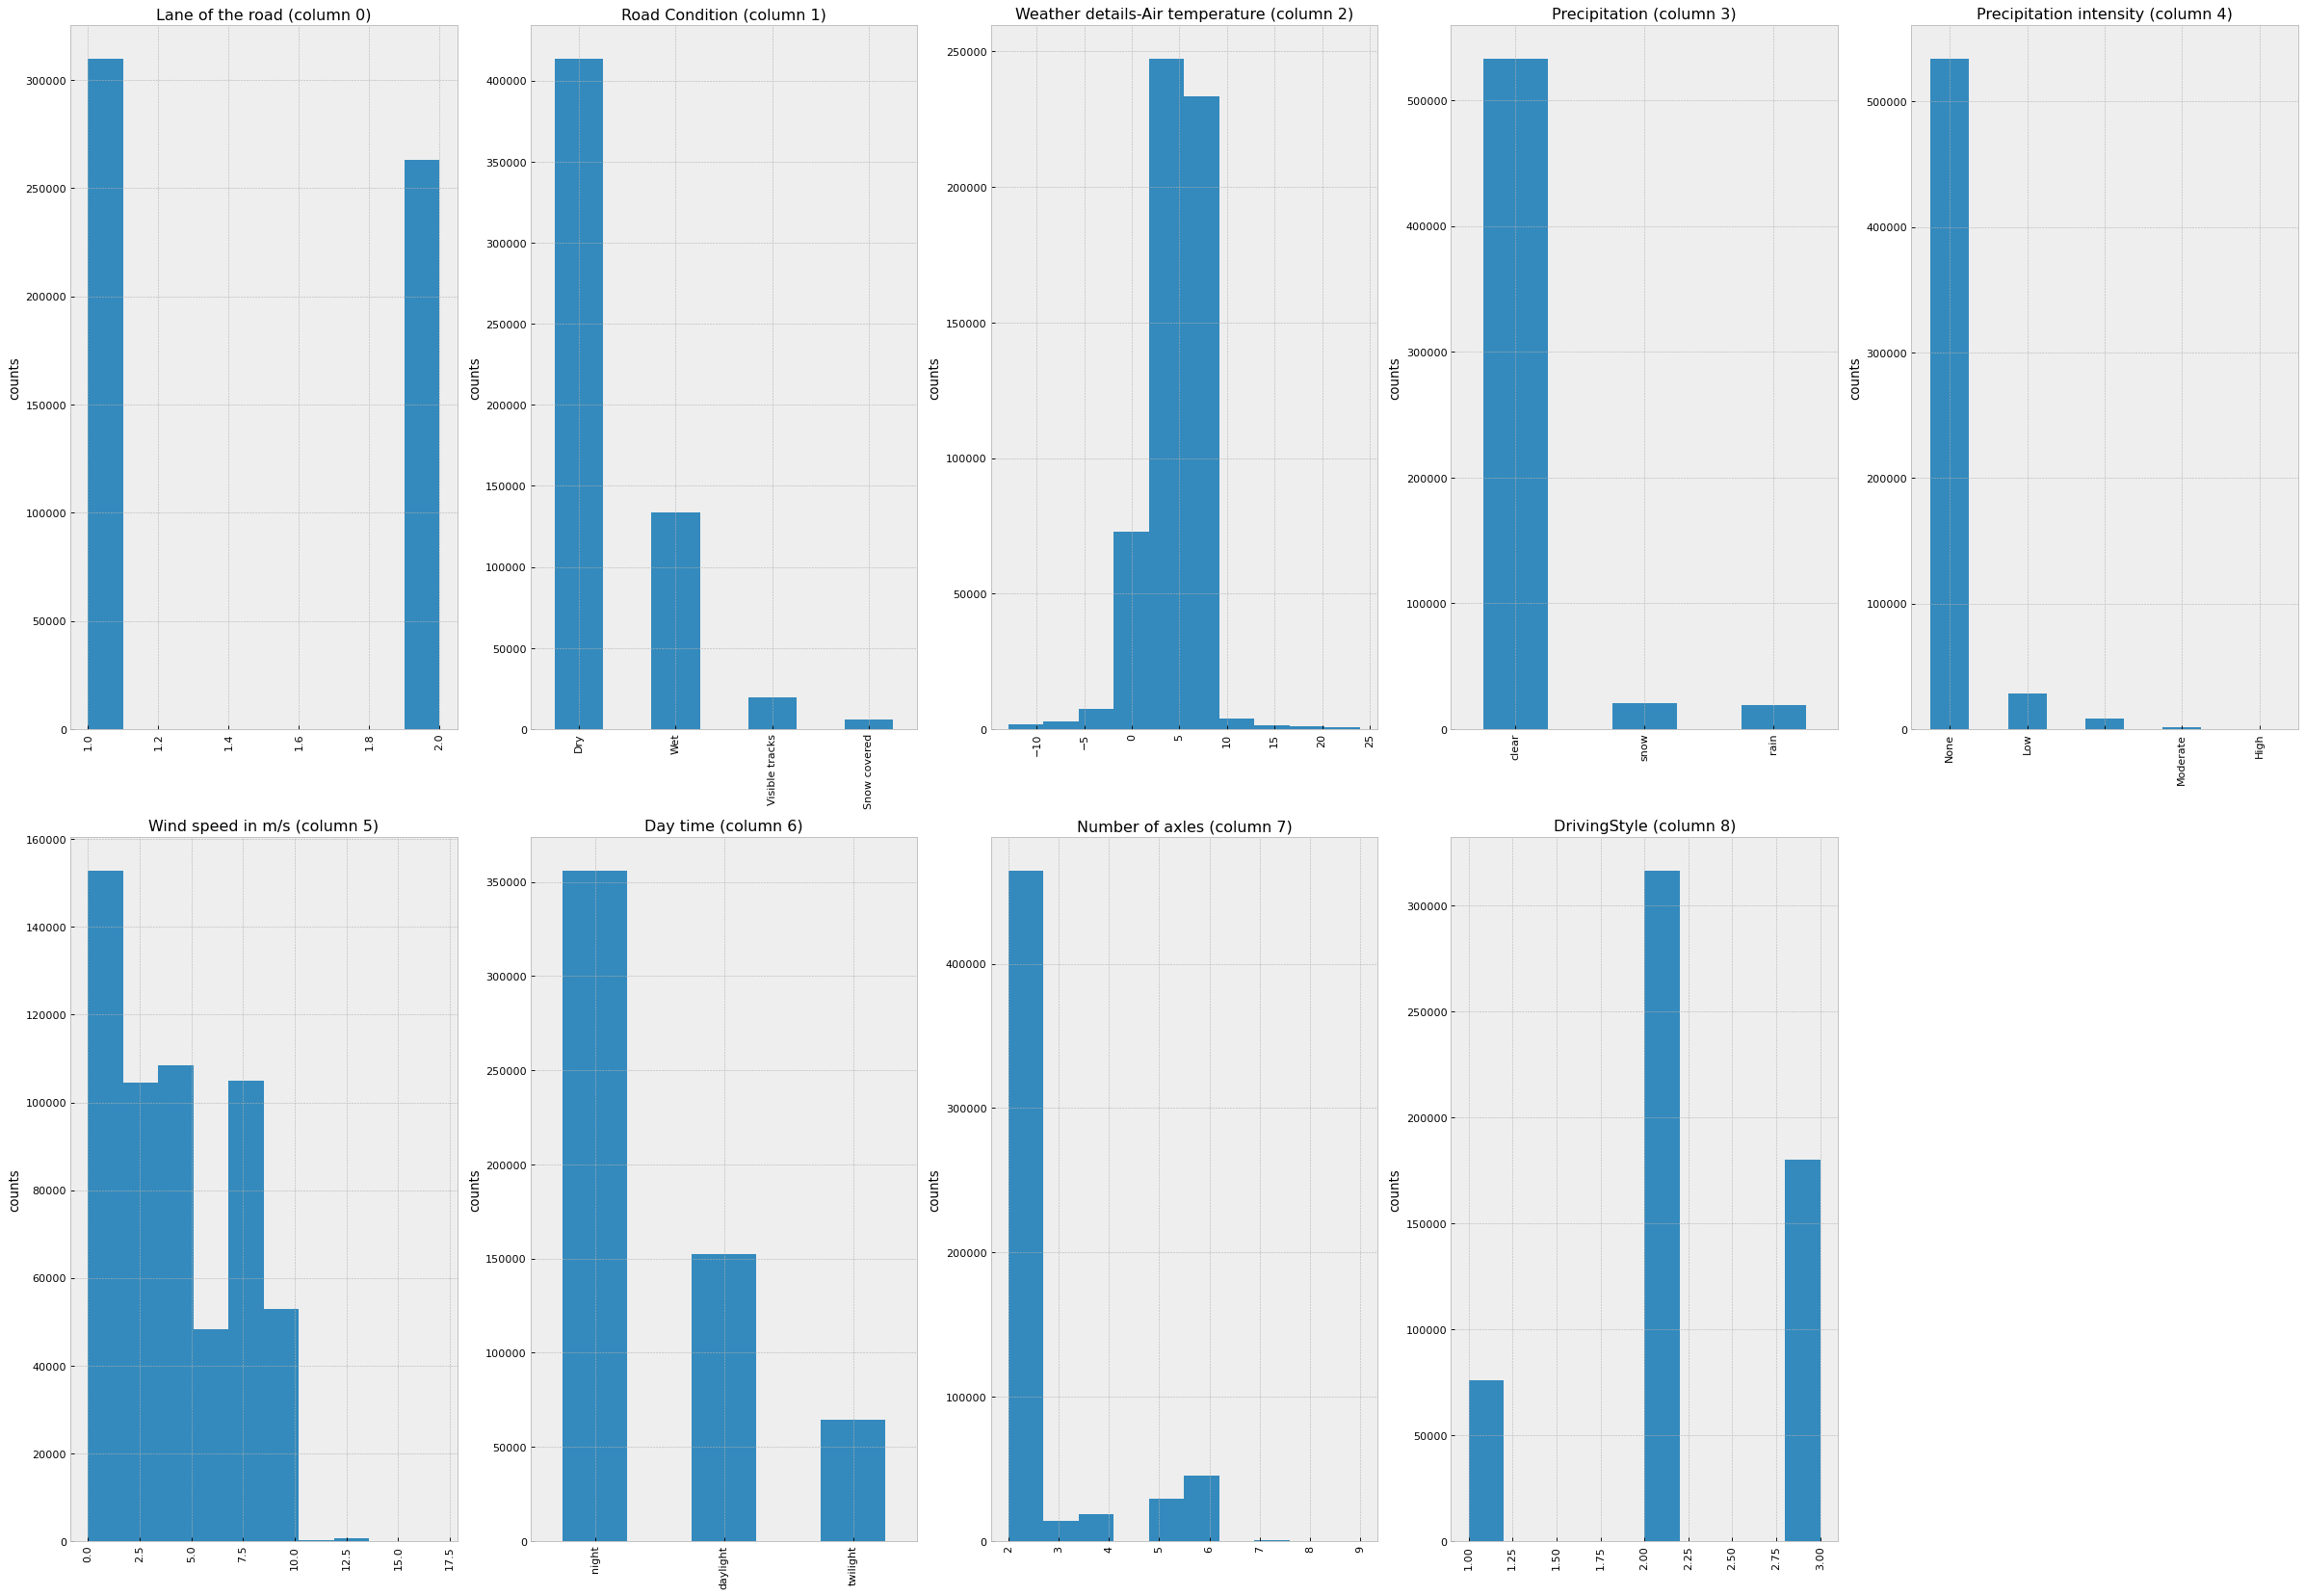

In [108]:
plotPerColumnDistribution(df, 10, 5)

<AxesSubplot:>

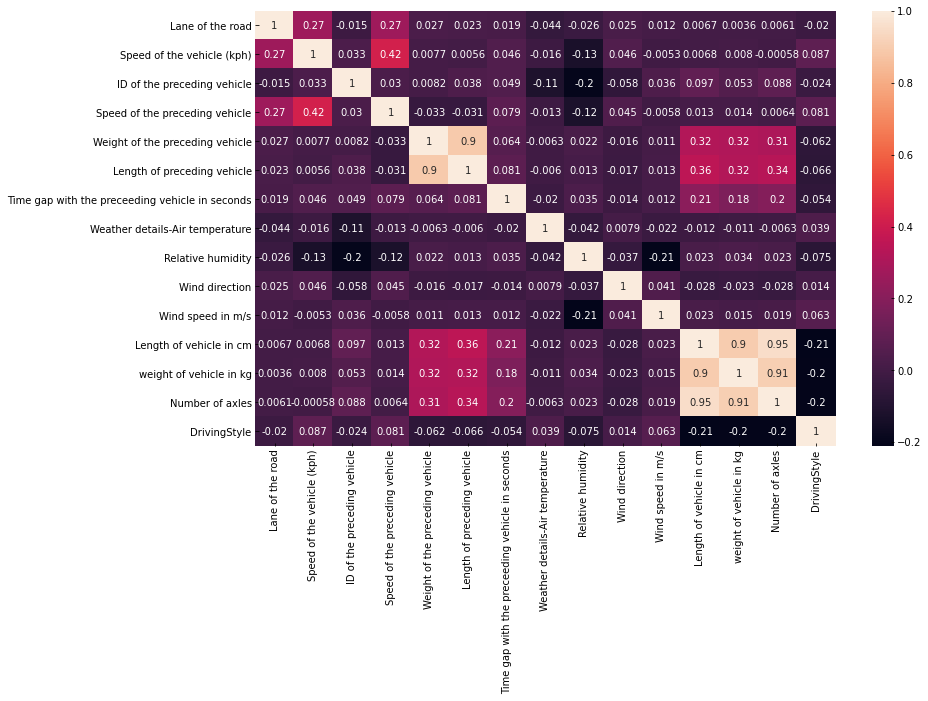

In [109]:
plt.figure(figsize=(13,8))
sns.heatmap(df.corr(), annot=True )

In [110]:
plotScatterMatrix(df, 20, 15)

KeyboardInterrupt: 

In [107]:
# plot correlation heatmap to find out correlations

df.corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,Lane of the road,Speed of the vehicle (kph),ID of the preceding vehicle,Speed of the preceding vehicle,Weight of the preceding vehicle,Length of preceding vehicle,Time gap with the preceeding vehicle in seconds,Weather details-Air temperature,Relative humidity,Wind direction,Wind speed in m/s,Length of vehicle in cm,weight of vehicle in kg,Number of axles,DrivingStyle
Lane of the road,1.0,0.2666,-0.01485,0.2661,0.02687,0.02274,0.01938,-0.04409,-0.02564,0.02542,0.01194,0.006653,0.003623,0.006099,-0.01984
Speed of the vehicle (kph),0.2666,1.0,0.03262,0.4232,0.007707,0.005578,0.04587,-0.01592,-0.1264,0.04635,-0.005281,0.006776,0.008032,-0.0005768,0.08696
ID of the preceding vehicle,-0.01485,0.03262,1.0,0.02961,0.008183,0.03846,0.04945,-0.1131,-0.1975,-0.05846,0.03614,0.09652,0.05269,0.0875,-0.02373
Speed of the preceding vehicle,0.2661,0.4232,0.02961,1.0,-0.03313,-0.031,0.07882,-0.01293,-0.1219,0.04502,-0.005803,0.01316,0.01427,0.006373,0.08094
Weight of the preceding vehicle,0.02687,0.007707,0.008183,-0.03313,1.0,0.895,0.0639,-0.006275,0.02209,-0.01589,0.01128,0.3223,0.3187,0.3085,-0.06199
Length of preceding vehicle,0.02274,0.005578,0.03846,-0.031,0.895,1.0,0.08119,-0.00605,0.01321,-0.01695,0.01266,0.3559,0.3202,0.3372,-0.06576
Time gap with the preceeding vehicle in seconds,0.01938,0.04587,0.04945,0.07882,0.0639,0.08119,1.0,-0.0196,0.03475,-0.01393,0.01233,0.214,0.1753,0.1961,-0.05418
Weather details-Air temperature,-0.04409,-0.01592,-0.1131,-0.01293,-0.006275,-0.00605,-0.0196,1.0,-0.04203,0.007948,-0.02163,-0.01223,-0.01066,-0.006337,0.0386
Relative humidity,-0.02564,-0.1264,-0.1975,-0.1219,0.02209,0.01321,0.03475,-0.04203,1.0,-0.03702,-0.2093,0.02259,0.0339,0.02271,-0.07479
Wind direction,0.02542,0.04635,-0.05846,0.04502,-0.01589,-0.01695,-0.01393,0.007948,-0.03702,1.0,0.04097,-0.02782,-0.02307,-0.02804,0.01355


# Descriptive Stats

In [41]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Lane of the road,573008.0,1.459070,0.498322,1.0,1.0,1.0,2.00,2.0
Speed of the vehicle (kph),573008.0,82.358939,9.002635,8.0,77.0,82.0,87.00,161.0
ID of the preceding vehicle,573008.0,445047.178771,280356.101273,20.0,133643.0,589458.5,696912.25,794435.0
Speed of the preceding vehicle,573008.0,82.483674,9.054297,0.0,78.0,82.0,87.00,161.0
Weight of the preceding vehicle,573008.0,4319.725737,6722.555077,3.0,1488.0,1817.0,2368.00,69548.0
Length of preceding vehicle,573008.0,739.268604,436.661879,102.0,527.0,556.0,609.00,2981.0
Time gap with the preceeding vehicle in seconds,573008.0,63.181075,127.652522,1.0,3.0,16.0,65.00,1797.0
Weather details-Air temperature,573008.0,4.726962,3.199411,-13.0,2.0,5.0,7.00,24.0
Relative humidity,573008.0,60.260948,17.937808,16.0,46.0,57.0,76.00,97.0
Wind direction,573008.0,183.886736,91.411415,6.0,146.0,180.0,214.00,360.0


count    573008.000000
mean          2.182113
std           0.643547
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           3.000000
Name: DrivingStyle, dtype: float64


C:\Users\AG95028\AppData\Local\conda\conda\envs\myenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


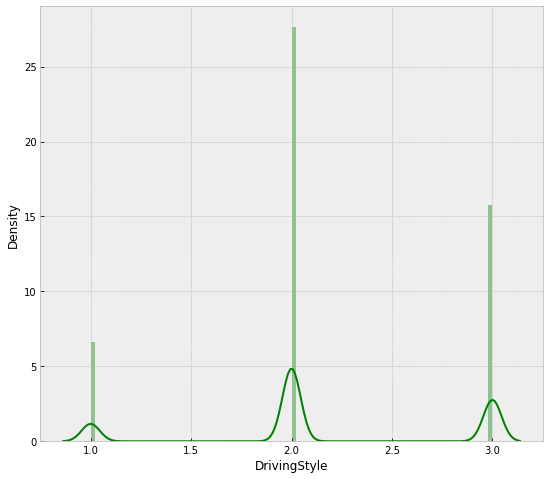

In [42]:
print(df['DrivingStyle'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['DrivingStyle'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [43]:
list(set(df.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

In [44]:
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 4 categorical variables

The categorical variables are :

 ['Road Condition', 'Precipitation', 'Precipitation intensity', 'Day time']


In [45]:
df[categorical].head()

Road Condition Precipitation  \
ID       datetime                                           
DR_24526 2012-03-21 09:14:00            Dry         clear   
         2012-03-21 09:15:00            Dry         clear   
         2012-03-21 09:15:00            Dry         clear   
         2012-03-21 09:15:00            Dry         clear   
         2012-03-21 09:15:00            Dry         clear   

                             Precipitation intensity  Day time  
ID       datetime                                               
DR_24526 2012-03-21 09:14:00                    None  daylight  
         2012-03-21 09:15:00                    None  daylight  
         2012-03-21 09:15:00                    None  daylight  
         2012-03-21 09:15:00                    None  daylight  
         2012-03-21 09:15:00                    None  daylight

In [46]:
for var in categorical: 
    print(df[var].value_counts())

Dry               413630
Wet               133902
Visible tracks     19734
Snow covered        5742
Name: Road Condition, dtype: int64
clear    533281
snow      20478
rain      19249
Name: Precipitation, dtype: int64
None        534215
Low          28527
              8284
Moderate      1679
High           303
Name: Precipitation intensity, dtype: int64
night       356119
daylight    152297
twilight     64592
Name: Day time, dtype: int64


In [47]:
df[categorical].isnull().sum()

Road Condition             0
Precipitation              0
Precipitation intensity    0
Day time                   0
dtype: int64

In [48]:
# check for cardinality in categorical variables

for var in categorical:
    
    print(var, ' contains ', len(df[var].unique()), ' labels')

Road Condition  contains  4  labels
Precipitation  contains  3  labels
Precipitation intensity  contains  5  labels
Day time  contains  3  labels


In [49]:
numerical = [var for var in df.columns if df[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :\n\n', numerical)

There are 15 numerical variables

The numerical variables are :

 ['Lane of the road', 'Speed of the vehicle (kph)', 'ID of the preceding vehicle', 'Speed of the preceding vehicle', 'Weight of the preceding vehicle', 'Length of preceding vehicle', 'Time gap with the preceeding vehicle in seconds', 'Weather details-Air temperature', 'Relative humidity', 'Wind direction', 'Wind speed in m/s', 'Length of vehicle in cm', 'weight of vehicle in kg', 'Number of axles', 'DrivingStyle']


In [50]:
df[numerical].isnull().sum()

Lane of the road                                   0
Speed of the vehicle (kph)                         0
ID of the preceding vehicle                        0
Speed of the preceding vehicle                     0
Weight of the preceding vehicle                    0
Length of preceding vehicle                        0
Time gap with the preceeding vehicle in seconds    0
Weather details-Air temperature                    0
Relative humidity                                  0
Wind direction                                     0
Wind speed in m/s                                  0
Length of vehicle in cm                            0
weight of vehicle in kg                            0
Number of axles                                    0
DrivingStyle                                       0
dtype: int64

In [53]:
df.head()

Lane of the road  Speed of the vehicle (kph)  \
ID       datetime                                                            
DR_24526 2012-03-21 09:14:00                 1                          81   
         2012-03-21 09:15:00                 1                          88   
         2012-03-21 09:15:00                 1                          88   
         2012-03-21 09:15:00                 1                          88   
         2012-03-21 09:15:00                 1                          88   

                              ID of the preceding vehicle  \
ID       datetime                                           
DR_24526 2012-03-21 09:14:00                        57227   
         2012-03-21 09:15:00                        57229   
         2012-03-21 09:15:00                        57229   
         2012-03-21 09:15:00                        57229   
         2012-03-21 09:15:00                        57229   

                              Speed of the preceding vehicle  \
ID       datetime                                              
DR_24526 2012-03-21 09:14:00                              87   
         2012-03-21 09:15:00                              81   
         2012-03-21 09:15:00                              81   
         2012-03-21 09:15:00                              81   
         2012-03-21 09:15:00                              81   

                              Weight of the preceding vehicle  \
ID       datetime                                               
DR_24526 2012-03-21 09:14:00                            16986   
         2012-03-21 09:15:00                             1708   
         2012-03-21 09:15:00                             1708   
         2012-03-21 09:15:00                             1708   
         2012-03-21 09:15:00                             1708   

                              Length of preceding vehicle  \
ID       datetime                                           
DR_24526 2012-03-21 09:14:00                          941   
         2012-03-21 09:15:00                          551   
         2012-03-21 09:15:00                          551   
         2012-03-21 09:15:00                          551   
         2012-03-21 09:15:00                          551   

                              Time gap with the preceeding vehicle in seconds  \
ID       datetime                                                               
DR_24526 2012-03-21 09:14:00                                             94.0   
         2012-03-21 09:15:00                                             11.0   
         2012-03-21 09:15:00                                             11.0   
         2012-03-21 09:15:00                                             11.0   
         2012-03-21 09:15:00                                             11.0   

                             Road Condition  Weather details-Air temperature  \
ID       datetime                                                              
DR_24526 2012-03-21 09:14:00            Dry                              7.0   
         2012-03-21 09:15:00            Dry                              7.0   
         2012-03-21 09:15:00            Dry                              7.0   
         2012-03-21 09:15:00            Dry                              7.0   
         2012-03-21 09:15:00            Dry                              7.0   

                             Precipitation Precipitation intensity  \
ID       datetime                                                    
DR_24526 2012-03-21 09:14:00         clear                    None   
         2012-03-21 09:15:00         clear                    None   
         2012-03-21 09:15:00         clear                    None   
         2012-03-21 09:15:00         clear                    None   
         2012-03-21 09:15:00         clear                    None   

                              Relative humidity  Wind direction  \
ID       datetime                  

In [77]:
X = df.drop(['DrivingStyle'], axis=1)
Y = df['DrivingStyle']

<AxesSubplot:>

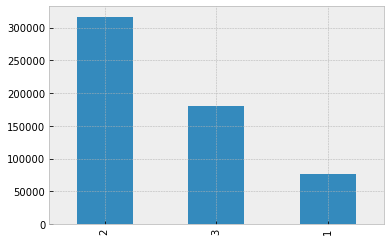

In [78]:
#before smote 
Y.value_counts().plot.bar()

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [80]:
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']
categorical

['Road Condition', 'Precipitation', 'Precipitation intensity', 'Day time']

In [81]:

numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']
numerical

['Lane of the road',
 'Speed of the vehicle (kph)',
 'ID of the preceding vehicle',
 'Speed of the preceding vehicle',
 'Weight of the preceding vehicle',
 'Length of preceding vehicle',
 'Time gap with the preceeding vehicle in seconds',
 'Weather details-Air temperature',
 'Relative humidity',
 'Wind direction',
 'Wind speed in m/s',
 'Length of vehicle in cm',
 'weight of vehicle in kg',
 'Number of axles']

In [82]:
# print percentage of missing values in the categorical variables in training set
X_train[categorical].isnull().mean()

Road Condition             0.0
Precipitation              0.0
Precipitation intensity    0.0
Day time                   0.0
dtype: float64

In [83]:
# print categorical variables with missing data
for col in categorical:
    if X_train[col].isnull().mean()>0:
        print(col, (X_train[col].isnull().mean()))

In [84]:
# impute missing categorical variables with most frequent value

for df2 in [X_train, X_test]:
    df2['Road Condition'].fillna(X_train['Road Condition'].mode()[0], inplace=True)
    df2['Precipitation'].fillna(X_train['Precipitation'].mode()[0], inplace=True)
    df2['Precipitation intensity'].fillna(X_train['Precipitation intensity'].mode()[0], inplace=True)
    df2['Day time'].fillna(X_train['Day time'].mode()[0], inplace=True)

C:\Users\AG95028\AppData\Local\conda\conda\envs\myenv\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [85]:
# check missing values in categorical variables in X_train
X_train[categorical].isnull().sum()

Road Condition             0
Precipitation              0
Precipitation intensity    0
Day time                   0
dtype: int64

# Encoding Categorical Variables

In [86]:
# encode categorical variables with one-hot encoding
encoder = ce.OneHotEncoder(cols=[
 'Road Condition',
 'Precipitation',
 'Precipitation intensity',
 'Day time'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

C:\Users\AG95028\AppData\Local\conda\conda\envs\myenv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


# Impliment Synthetic Minority Over-Sampling Technique (SMOTE)

AFTER SMOTE


<AxesSubplot:>

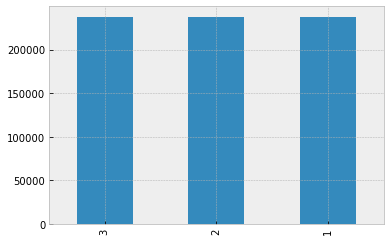

In [87]:
# implement smote now
smote = SMOTE(random_state=42)
X,Y  = smote.fit_resample(X_train, Y_train)

print("AFTER SMOTE")
Y.value_counts().plot.bar()

# check the shape of X_train and X_test
#X_train.shape, X_test.shape


In [75]:
# Post SMOTE
X.shape,Y.shape

((713037, 29), (713037,))

<AxesSubplot:>

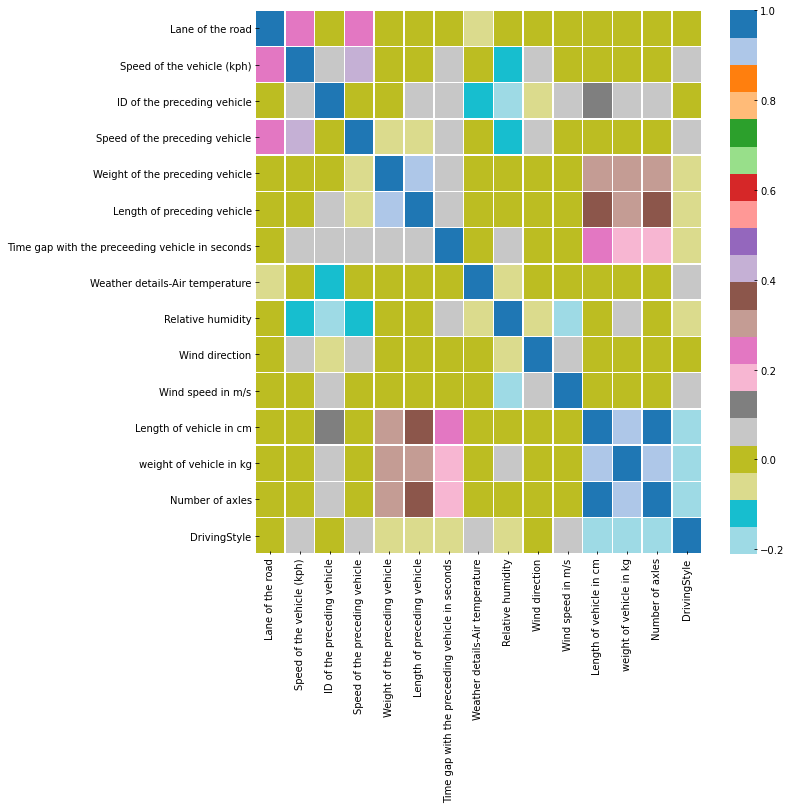

In [76]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap='tab20_r',linewidths=.5,annot=False)

# Building models

# Logistic Regression

In [90]:
clf = LogisticRegression()
clf.fit(X,Y)
y_pred = clf.predict(X_test)

acc_lr = accuracy_score(Y_test, y_pred)
conf = confusion_matrix(Y_test, y_pred)
clf_report = classification_report(Y_test, y_pred)
print(f"Accuracy Score of Logistic Regression : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

C:\Users\AG95028\AppData\Local\conda\conda\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy Score of Logistic Regression : 0.4350445369000084
Confusion Matrix : 
[[ 8266  5574  5085]
 [10353 34989 33671]
 [ 6031 20217 19066]]
Classification Report : 
              precision    recall  f1-score   support

           1       0.34      0.44      0.38     18925
           2       0.58      0.44      0.50     79013
           3       0.33      0.42      0.37     45314

    accuracy                           0.44    143252
   macro avg       0.41      0.43      0.42    143252
weighted avg       0.47      0.44      0.44    143252



# Logistic Regression with Cross Validation

In [91]:
clf = LogisticRegressionCV(cv = 5)
clf.fit(X,Y)
y_pred = clf.predict(X_test)

acc_lr = accuracy_score(Y_test, y_pred)
conf = confusion_matrix(Y_test, y_pred)
clf_report = classification_report(Y_test, y_pred)
print(f"Accuracy Score of Logistic Regression : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

C:\Users\AG95028\AppData\Local\conda\conda\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\AG95028\AppData\Local\conda\conda\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

Accuracy Score of Logistic Regression : 0.4395261497221679
Confusion Matrix : 
[[ 8694  5728  4503]
 [12398 36905 29710]
 [ 7042 20908 17364]]
Classification Report : 
              precision    recall  f1-score   support

           1       0.31      0.46      0.37     18925
           2       0.58      0.47      0.52     79013
           3       0.34      0.38      0.36     45314

    accuracy                           0.44    143252
   macro avg       0.41      0.44      0.42    143252
weighted avg       0.47      0.44      0.45    143252



# Decision Tree Classifier

In [92]:
clf = DecisionTreeClassifier()
clf.fit(X, Y)
y_pred = clf.predict(X_test)

acc_dtc = accuracy_score(Y_test, y_pred)
conf = confusion_matrix(Y_test, y_pred)
clf_report = classification_report(Y_test, y_pred)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Decision Tree is : 0.9908762181330801
Confusion Matrix : 
[[18672   142   111]
 [  254 78368   391]
 [  147   262 44905]]
Classification Report : 
              precision    recall  f1-score   support

           1       0.98      0.99      0.98     18925
           2       0.99      0.99      0.99     79013
           3       0.99      0.99      0.99     45314

    accuracy                           0.99    143252
   macro avg       0.99      0.99      0.99    143252
weighted avg       0.99      0.99      0.99    143252



# RandomForest Classifier

In [94]:
random_clf = RandomForestClassifier()
random_clf.fit(X, Y)

y_pred_random_clf = random_clf.predict(X_test)

acc_rd_clf = accuracy_score(Y_test, y_pred_random_clf)
conf = confusion_matrix(Y_test, y_pred_random_clf)
clf_report = classification_report(Y_test, y_pred_random_clf)

print(f"Accuracy Score of Random Forest is : {acc_rd_clf}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Random Forest is : 0.991441655264848
Confusion Matrix : 
[[18774   112    39]
 [  384 78243   386]
 [  194   111 45009]]
Classification Report : 
              precision    recall  f1-score   support

           1       0.97      0.99      0.98     18925
           2       1.00      0.99      0.99     79013
           3       0.99      0.99      0.99     45314

    accuracy                           0.99    143252
   macro avg       0.99      0.99      0.99    143252
weighted avg       0.99      0.99      0.99    143252



# Feature Importance

In [95]:
# create the classifier with n_estimators = 100

clf = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set

clf.fit(X, Y)

RandomForestClassifier(random_state=0)

In [96]:
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

feature_scores

Length of vehicle in cm                            0.140912
weight of vehicle in kg                            0.121460
ID of the preceding vehicle                        0.110061
Relative humidity                                  0.099726
Day time_2                                         0.077497
Wind direction                                     0.075413
Wind speed in m/s                                  0.066949
Weather details-Air temperature                    0.063360
Road Condition_1                                   0.033341
Day time_1                                         0.024733
Number of axles                                    0.023221
Weight of the preceding vehicle                    0.021450
Road Condition_2                                   0.020854
Time gap with the preceeding vehicle in seconds    0.020713
Speed of the vehicle (kph)                         0.020534
Length of preceding vehicle                        0.019846
Speed of the preceding vehicle          

<AxesSubplot:>

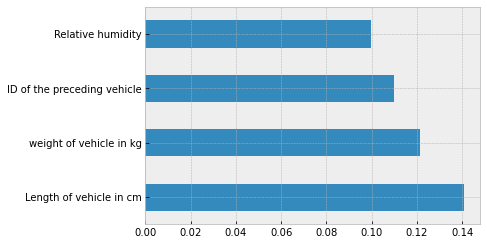

In [97]:
(pd.Series(clf.feature_importances_, index=X.columns)
   .nlargest(4)
   .plot(kind='barh'))

In [98]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

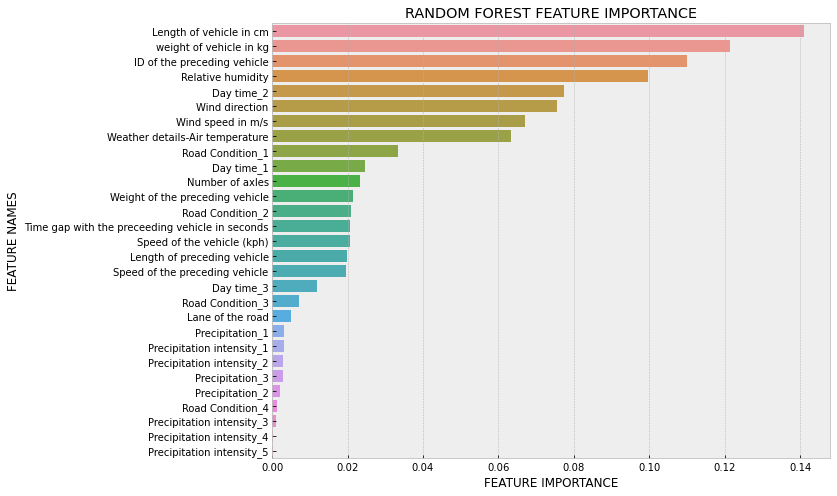

In [99]:
plot_feature_importance(clf.feature_importances_,X.columns,'RANDOM FOREST')

# The above plot confims that the least important feature is Precipitation_Intensity_5 and most important feature is Length of vehicle in cm followed by weight of vehicle in kg

# Build the Random Forest model on selected features

In [100]:
# drop the least important feature from X_train and X_test

X_train = X_train.drop(['Precipitation intensity_5'], axis=1)

X_test = X_test.drop(['Precipitation intensity_5'], axis=1)

In [105]:
# instantiate the classifier with n_estimators = 100

clf = RandomForestClassifier(n_estimators=100, random_state=0)



# fit the model to the training set

clf.fit(X_train, Y_train)


# Predict on the test set results

y_pred = clf.predict(X_test)



# Check accuracy score 

print('Model accuracy score with Precipitation intensity_5 variable removed : {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))

Model accuracy score with Precipitation intensity_5 variable removed : 0.9936


In [104]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99     18925
           2       1.00      0.99      1.00     79013
           3       0.99      0.99      0.99     45314

    accuracy                           0.99    143252
   macro avg       0.99      0.99      0.99    143252
weighted avg       0.99      0.99      0.99    143252



# Interpretation

# I have removed the Precipitation intensity_5 variable from the model, rebuild it and checked its accuracy.The accuracy of the model now comes out to be 0.9936.So, we can see that the model accuracy has been improved with Precipitation intensity_5 variable removed from the model.


In [112]:
def label_drvingstyle_category(row):
    if row['DrivingStyle'] == 1:
        return 'Aggressive'
    if row['DrivingStyle'] == 2:
        return 'Normal'
    if row['DrivingStyle'] == 3:
        return 'Vague'
    return 'Unknown'

In [113]:
df['DrivingStyle_Category'] = df.apply (lambda row: label_drvingstyle_category (row),axis=1)